In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p = np.polynomial.chebyshev.Chebyshev(coef=[0,0,0,1],domain=[0,1])

In [4]:
x = np.linspace(0,1,100)

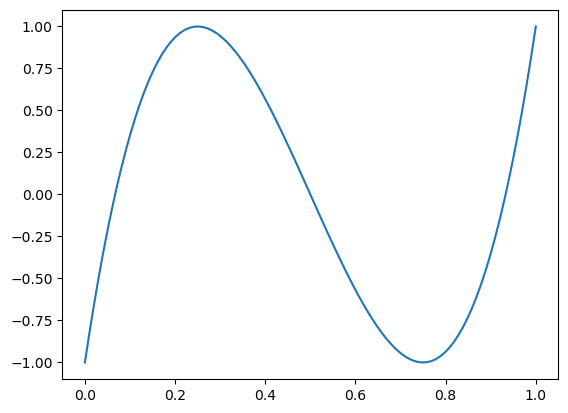

In [5]:
plt.plot(x,p(x))

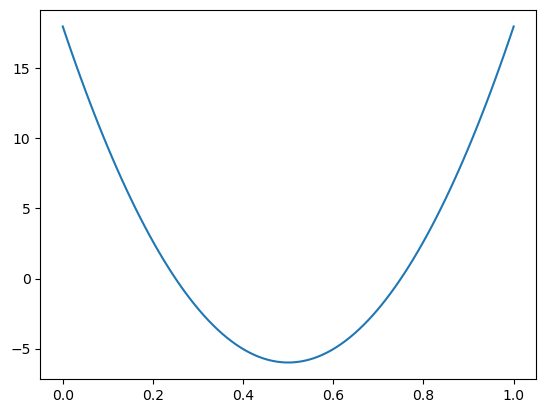

In [6]:
plt.plot(x,p.deriv(m=1)(x))

In [7]:
p

Chebyshev([0., 0., 0., 1.], domain=[0., 1.], window=[-1,  1])

In [8]:
p.deriv(m=1)

Chebyshev([ 6.,  0., 12.], domain=[0., 1.], window=[-1.,  1.])

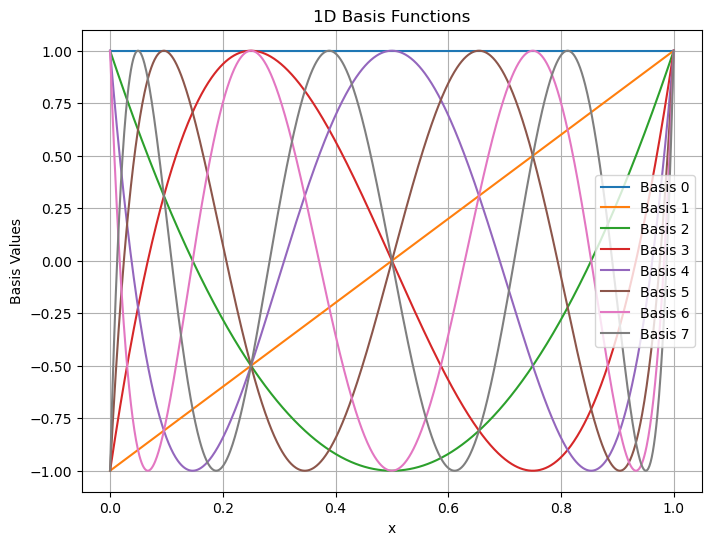

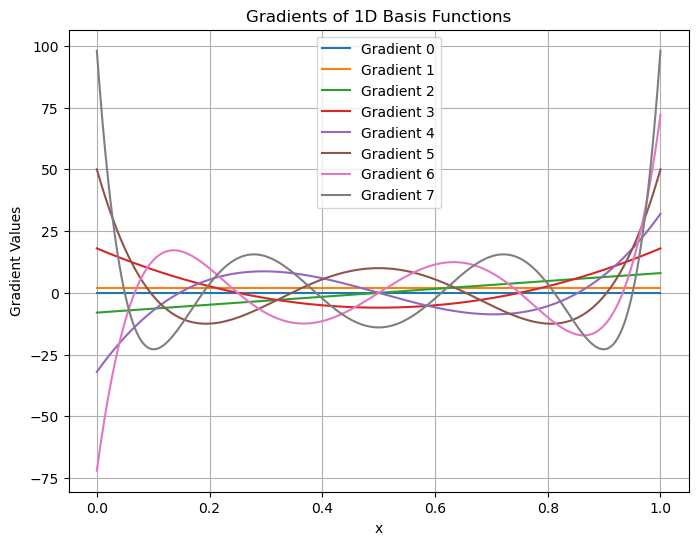

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import opt_einsum
from scipy.interpolate import BSpline

class ChebyshevTBasis1D:
    def __init__(self, h):
        self.h = h # Number of basis functions

    def basis_function(self, n):
        c = np.zeros(self.h)
        c[n] = 1

        basisfunction = np.polynomial.chebyshev.Chebyshev(coef=c,domain=[0,1])
        return basisfunction
    
    def forward(self, x):
        basis_values = np.zeros((x.shape[0],self.h))
        for n in range(self.h):
            basis_values[:, n] = self.basis_function(n)(x)
        return basis_values
    
    def basis_gradient(self, n):
        basisfunction = self.basis_function(n)
        derivative = basisfunction.deriv(m=1)
        return derivative
    
    def grad(self, x):
        basis_gradients = np.zeros((x.shape[0],self.h))
        for n in range(self.h):
            basis_grad = self.basis_gradient(n)(x)
            basis_gradients[:, n] = basis_grad
        return basis_gradients

    def plot_1d_basis(self):
        resolution = 1000
        x_values = np.linspace(0, 1, resolution)  # Adjusted range for x_values
        basis_matrix = self.forward(x_values)
        plt.figure(figsize=(8, 6))
        for i in range(self.h):
            plt.plot(x_values, basis_matrix[:,i], label=f'Basis {i}')
        plt.title(f'1D Basis Functions')
        plt.xlabel('x')
        plt.ylabel('Basis Values')
        plt.legend()
        plt.grid(True)
        # plt.savefig("BSpline1D.svg", bbox_inches='tight', transparent=True)
        plt.show()
        
    def plot_1d_basis_gradients(self):
        """
        Plot the gradients of the 1D B-spline basis functions for a specified dimension.

        Args:
        dim_idx (int): Index of the dimension for which to plot the basis function gradients.
        """
        resolution = 1000
        x_values = np.linspace(0, 1, resolution)  # Use full knot span for x_values
        basis_gradients_matrix = self.grad(x_values)
        plt.figure(figsize=(8, 6))
        for i in range(self.h):
            plt.plot(x_values, basis_gradients_matrix[:, i], label=f'Gradient {i}')
        plt.title(f'Gradients of 1D Basis Functions')
        plt.xlabel('x')
        plt.ylabel('Gradient Values')
        plt.legend()
        plt.grid(True)
        # plt.savefig("BSplinegrad1D.svg", bbox_inches='tight', transparent=True)
        plt.show()

# Example usage for 1D B-spline basis functions
basis_1d = ChebyshevTBasis1D(h=8)

# Plot the 1D B-spline basis functions for dimension 0
basis_1d.plot_1d_basis()

# Plot the gradients of the 1D B-spline basis functions for dimension 0
basis_1d.plot_1d_basis_gradients()

In [70]:
class BasisTensorizer:
    def __init__(self, bases):
        self.bases = bases
        self.d = len(bases)
        self.n_basisfunctions = 1
        for i in range(len(bases)):
            self.n_basisfunctions *= bases[i].h_1d
    
    def forward(self, x):
        tensorproduct = self.bases[0].forward(x[:,0])
        newsize = self.bases[0].h_1d
        for i in range(1,self.d):
            newsize = newsize*self.bases[i].h_1d
            tensorproduct = opt_einsum.contract('Nm,Nn->Nmn', tensorproduct, self.bases[i].forward(x[:,i])).reshape(x.shape[0], newsize)
        return tensorproduct
    
    def grad(self, x):
        tensorproduct = np.zeros((x.shape[0], self.n_basisfunctions, self.d))
        for i in range(self.d):
            if i==0:
                tensorproduct_i = self.bases[0].grad(x[:,0])
            else:
                tensorproduct_i = self.bases[0].forward(x[:,0])
            newsize = self.bases[0].h_1d
            for j in range(1,self.d):
                newsize = newsize*self.bases[j].h_1d
                if j==i:
                    tensorproduct_i = opt_einsum.contract('Nm,Nn->Nmn', tensorproduct_i, self.bases[j].grad(x[:,j])).reshape(x.shape[0], newsize)
                else: 
                    tensorproduct_i = opt_einsum.contract('Nm,Nn->Nmn', tensorproduct_i, self.bases[j].forward(x[:,j])).reshape(x.shape[0], newsize)
            tensorproduct[:,:,i] = tensorproduct_i
        return tensorproduct
    
    def plot_2d_basis(self):
        resolution = 100
        x_0, x_1 = np.mgrid[0:1:resolution*1j, 0:1:resolution*1j]
        x = np.vstack([x_0.ravel(), x_1.ravel()]).T
        basis_values_2d = self.forward(x)
        h_x = self.bases[0].h_1d
        h_y = self.bases[1].h_1d
        fig, axes = plt.subplots(h_x, h_y, figsize=(h_y*4, h_x*3))
        for i in range(h_x):
            for j in range(h_y):
                ax = axes[i, j] if h_x > 1 and h_y > 1 else axes[max(i, j)]
                idx = i * h_y + j
                z = basis_values_2d[:, idx]
                c = ax.tripcolor(x[:,0], x[:,1], z)
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Basis ({i},{j})')
                ax.set_xlabel('x')
                ax.set_ylabel('y')
        plt.tight_layout()
        # plt.savefig("BSpline2D.svg", bbox_inches='tight', transparent=True)
        plt.show()
        
    def plot_2d_basis_gradients(self):
        resolution = 100
        x_0, x_1 = np.mgrid[0:1:resolution*1j, 0:1:resolution*1j]
        x = np.vstack([x_0.ravel(), x_1.ravel()]).T
        basis_gradients_2d = self.grad(x)
        h_x = self.bases[0].h_1d
        h_y = self.bases[1].h_1d
        fig, axes = plt.subplots(h_x, h_y, figsize=(h_y*4, h_x*3))
        for i in range(h_x):
            for j in range(h_y):
                ax = axes[i, j] if h_x > 1 and h_y > 1 else axes[max(i, j)]
                idx = i * h_y + j
                z = np.sum(basis_gradients_2d[:, idx, :]**2, axis=-1)**(1/2)
                # z = basis_gradients_2d[:, idx]
                c = ax.tripcolor(x[:,0], x[:,1], z)
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Gradient ({i},{j})')
                ax.set_xlabel('x')
                ax.set_ylabel('y')
        plt.tight_layout()
        # plt.savefig("BSplinegrad2D.svg", bbox_inches='tight', transparent=True)
        plt.show()

In [83]:
import sys
sys.path.insert(0, '../ml')
from basisfunctions import *

basis_x = ChebyshevTBasis1D(h=3)
basis_y = ChebyshevTBasis1D(h=3)

knots = np.array([0,0,0,0,0.2,0.4,0.6,0.8,1,1,1,1])
p = 3

# # Create the 2D B-spline basis generator
# basis_2d = BSplineBasis2D(knots1dx, knots1dy, polynomial_order)
basis_x = BSplineBasis1D(knot_vector=knots, polynomial_order=p)
basis_y = BSplineBasis1D(knot_vector=knots, polynomial_order=p)

bases = [basis_x, basis_y]

tensorizedbasis = BasisTensorizer(bases)

In [100]:
h = 8
p = 3
knots = np.zeros(p)
knots = np.append(knots, np.linspace(0, 1, h-p+1))
knots = np.append(knots, np.ones(p))
knots

array([0. , 0. , 0. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1. , 1. , 1. ])

In [84]:
x = np.random.uniform(size=(100,2))

tensorizedbasis.grad(x).shape

(100, 64, 2)

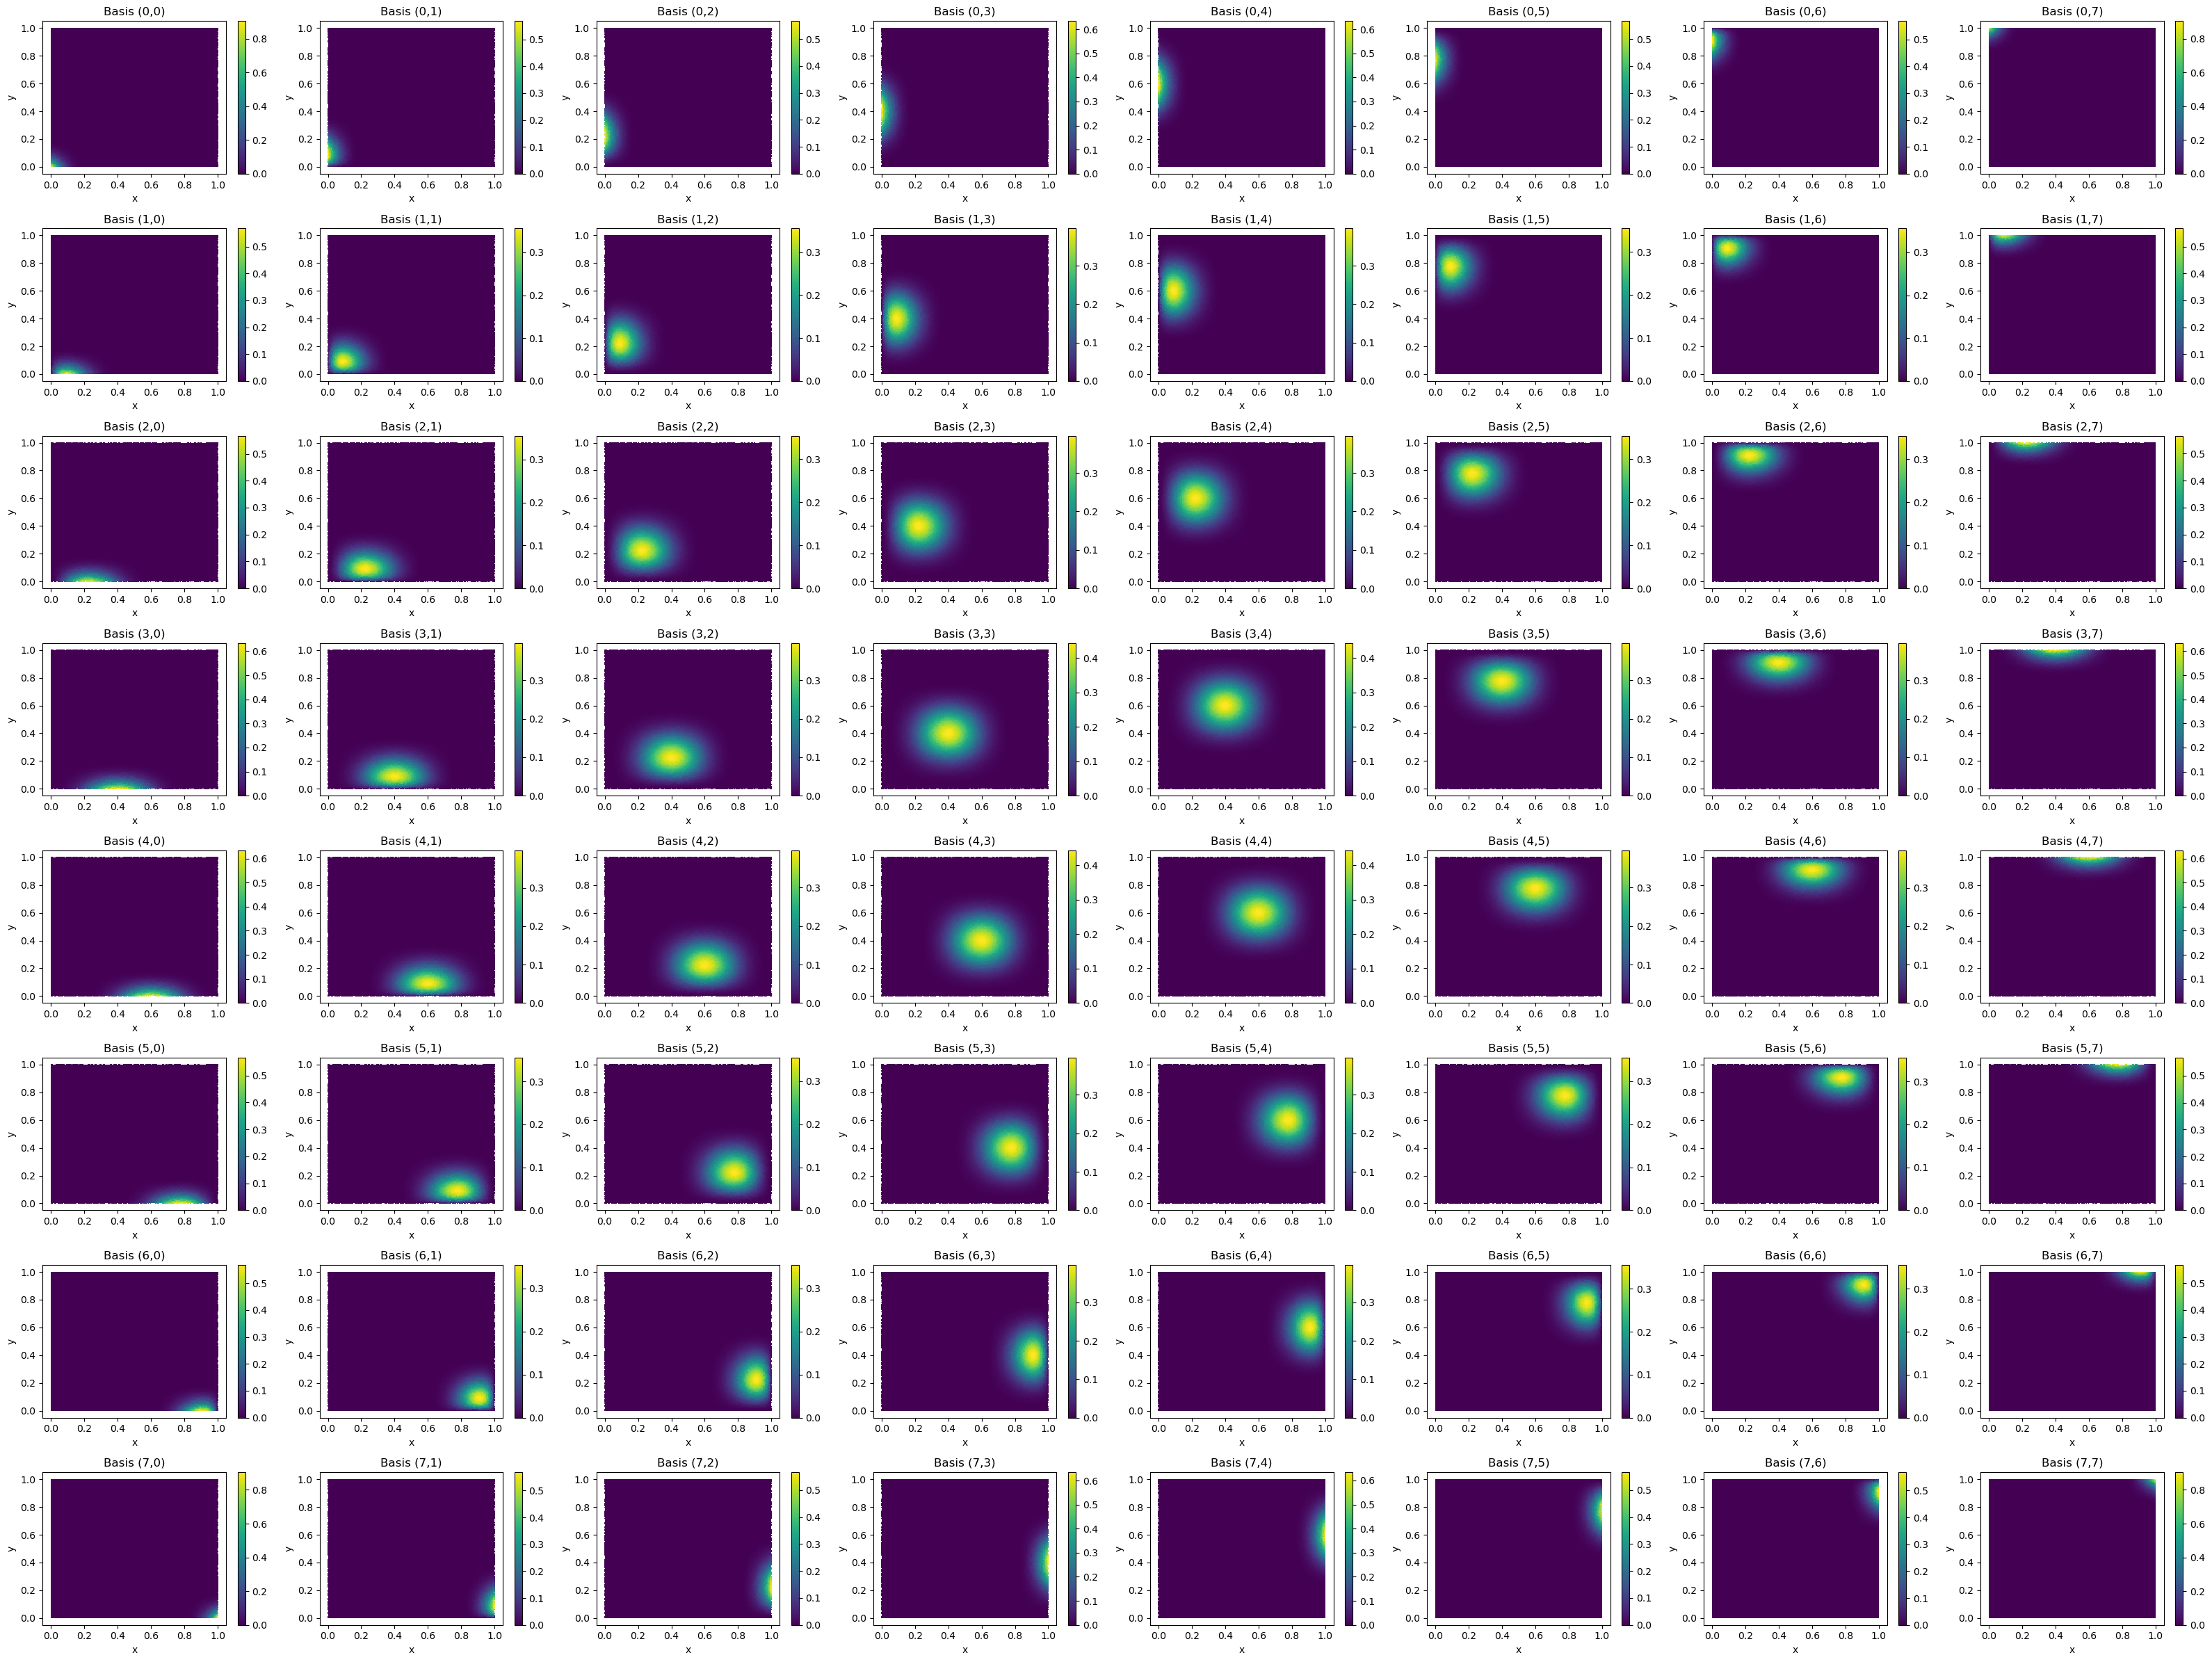

In [85]:
tensorizedbasis.plot_2d_basis()

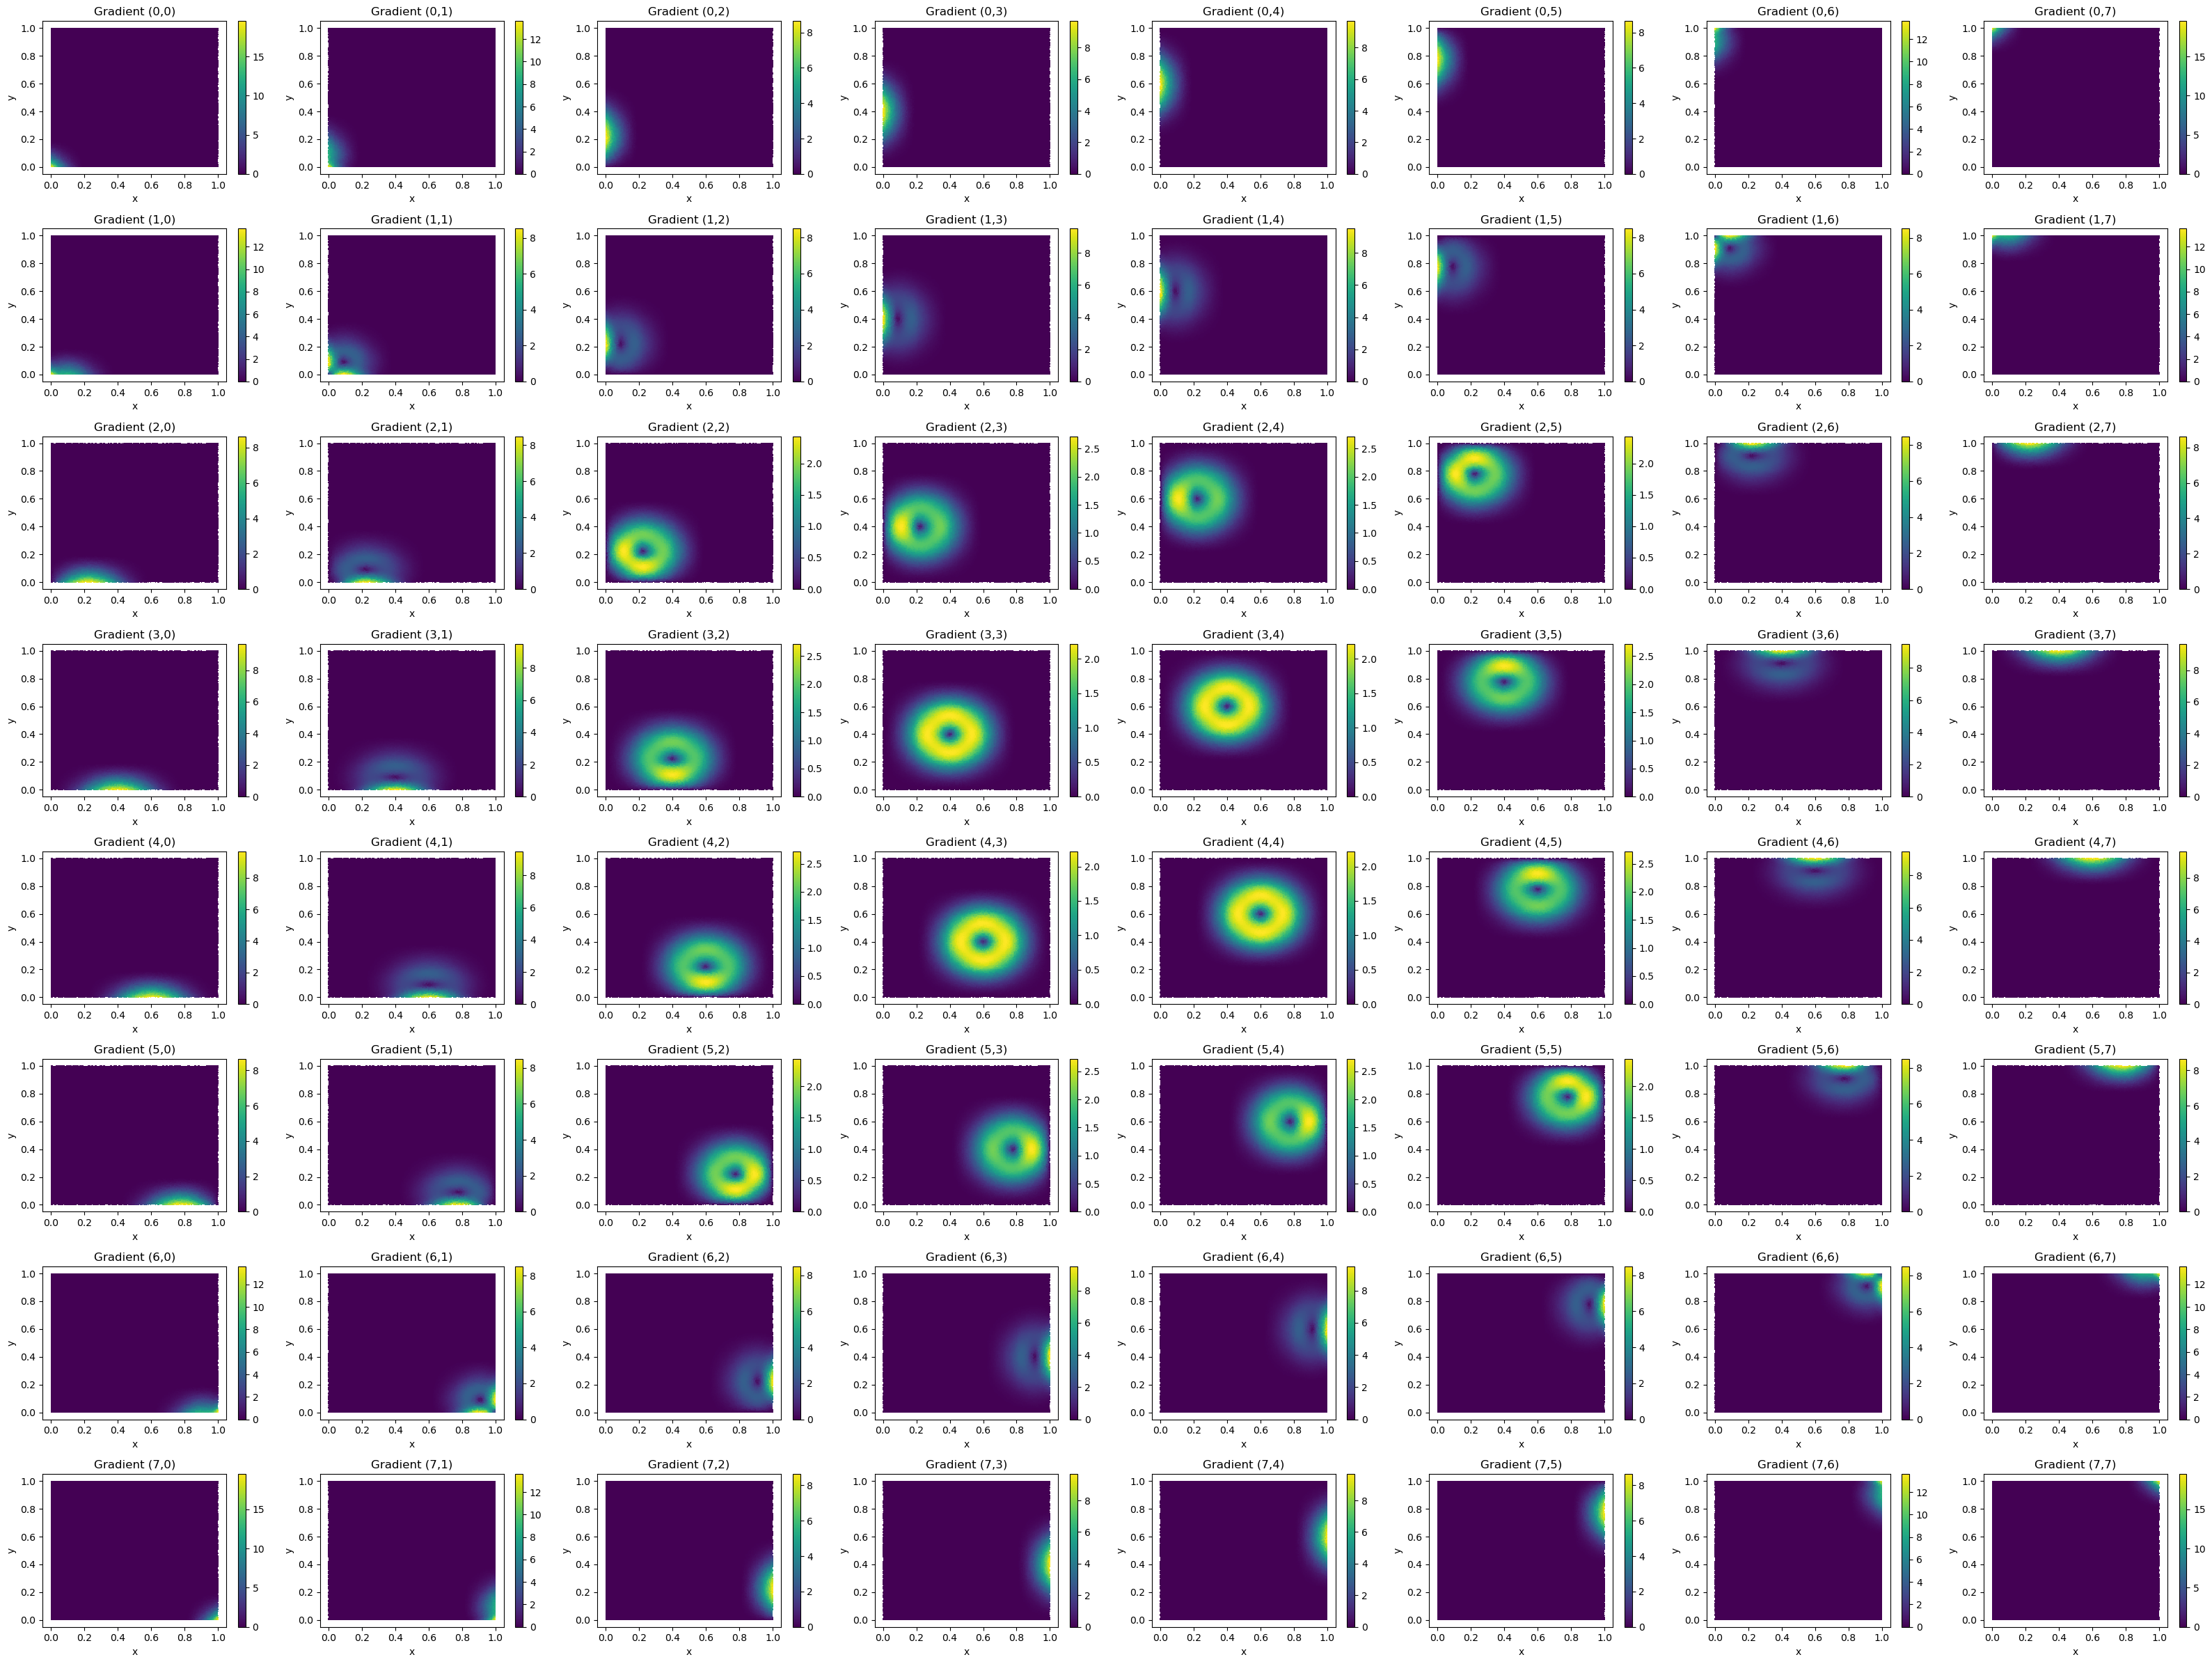

In [86]:
tensorizedbasis.plot_2d_basis_gradients()